# Explore Locations For Coffee Shops in Minsk, Belarus

* [Introduction](#Introduction)
* [Prepare Neighborhoods Data](#Prepare_Neighborhoods_Data)
* [Explore Existing Coffee Shops](#Explore_Existing_Coffee_Shops)
    * [Locations of Coffee Shops](#Locations_of_Coffee_Shops)
    * [Stats for Coffee Shops](#Stats_for_Coffee_Shops)
* [Explore The Neighborhoods](#Explore_The_Neighborhoods)
    * [Analyze Venues in The Neighborhoods](#Analyze_Venues_in_The_Neighborhoods)
    * [Cluster The Neighborhoods](#Cluster_The_Neighborhoods)

<a id="Introduction"></a>
## Introduction

Coffee is the world’s most popular beverage, it’s a universal drink that appeals to the majority of the population, and inexpensive to prepare. Thanks to this popularity coffee shops are considered profitable businesses that are relatively easy to operate. However, while it may appear to be easy, opening a coffee shop business requires a lot of insight, research, and planning.

Coffee shops are a great place to socialize: to meet friends, for informal meetings, or for students to catch up on schoolwork. Given the above having a great location is obviously very important for attracting customers. To be successful, you need the right location for your coffee shop. You probably want something centrally located, a place where people already gather. Moreover, while you may not have direct competitors, the substitutes also play an important role at filling the needs of your customers. Substitutes can include places like cafe or donut shops – or any fast food place that serves coffee.

Even, if you are franchising or buying an existing business the location is pre-selected but you should still do your research and decide whether the existing or selected location is a good one.

In this research I focus on choosing a right location for a new coffeу shop in Minsk, Belarus. I analyze location statistics for existing coffee shops, indirectly count customers and visits using check-ins, and look at existing substitutes.

### Data

Foursquare Public API is a main source of data in this study. Foursquare is a technology company that built a massive dataset of location data. Currently its location data is the most comprehensive out there, and quite accurate that it powers location data for many popular services like Apple Maps, Uber, Snapchat, Twitter and many others, and is currently being used by over 100,000 developers, and this number is only growing.

The Foursquare APIs will be used to extract the following informations:
- Locations of the existing coffee shops
- Details for existing coffee shops like number of checkins, number of unique users
- Locations and categories of substitute venues in coffee category

As a part of my analysis I also look at neighborhoods in Minsk. There are nine districts in the city, but this devision looks too coarse for our goals. At the same time, location of the post offices is well correlated with the distribution of the population, this information is extracted from the official post service site: http://belpost.by/branch/post/otdeleniya-sviazi/

I use the neighborhoods address information to define geographical coordinates using a geocoding service. This information allows us to extract statistics data for every neighborhood using Foursquare APIs. Later I explore, compare and cluster the neighborhoods to make suggestions on choosing the best locations for a new coffee shops.

<a id="Prepare_Neighborhoods_Data"></a>
## Prepare Neighborhoods Data

Let's start with preparing list of neighborhoods in Minsk, for this we scrape a list of post offices and find out goegraphical coordinates for the locations.

### Scraping the post offices list and loading data into a Pandas dataframe

We need to scrape the following page http://belpost.by/branch/post/otdeleniya-sviazi/ and extract addresses of the post offices. Let's start with loading the page's content.

In [1]:
import requests

page = requests.get('http://belpost.by/branch/post/otdeleniya-sviazi/')

Now, let's use BeautifulSoup to parse the page content.

In [2]:
from bs4 import BeautifulSoup
soup = BeautifulSoup(page.content, 'html.parser')
#print(soup.prettify())
table = soup.find_all('table')[2]

The dataframe will consist of two columns: *Postalcode* and *Address*.

In [3]:
import pandas as pd
import numpy as np

# define the dataframe columns
column_names = ['Postalcode', 'Address'] 

# instantiate the dataframe
post_offices = pd.DataFrame(columns=column_names)

for row in table.find('tbody').findAll('tr'):
    columns = row.findAll('td')
    
    if (len(columns) >= 2):
        po = columns[0].text.strip()
        
        if po.isdigit():
            po = str(int(po) + 220000)
            address = ''
            for child in columns[1].children:
                element = child.text if child.name == 'div' else str(child)
                element = element.replace('<br/>', '')
                element = element.strip()
                
                address = address + element + (' ' if element.endswith(',') else ', ')
                
            if address.endswith(', '):
                address = address[:-2]

            post_offices = post_offices.append({'Postalcode': po, 'Address': address}, ignore_index=True)
        
post_offices.head()

,Postalcode,Address
0,220001,"ул. Московская,16, 220001,г. Минск"
1,220002,"ул. Сторожевская,8, 220002,г. Минск"
2,220003,"ул. Одинцова, 113, 220003,г. Минск"
3,220004,"ул. М.Танка,36, к.2, 220004,г. Минск"
4,220005,"пр. Независимости,46, 220005,г. Минск"


Let's see how many items are in our dataframe.

In [4]:
post_offices.shape

(121, 2)

### Add geographical coordinates of the post offices

Now we add latittude and longitude coordinates for every address we extracted from the page. Let's use the Geocoder Python package.

In [5]:
# !pip install geocoder
import geocoder # import geocoder

I tried several providers and managed to get coordinates with ArcGIS provider: https://github.com/DenisCarriere/geocoder/blob/master/docs/providers/ArcGIS.rst

In [6]:
def get_coordinates(address):
    # initialize your variable to None
    lat_lng_coords = None

    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis(address)
        lat_lng_coords = g.latlng
        # print(address, ': ', lat_lng_coords)

    return lat_lng_coords[0], lat_lng_coords[1]

post_offices['Latitude'], post_offices['Longitude'] = zip(*post_offices['Address'].map(get_coordinates))

Let's check the dataframe.

In [7]:
post_offices.head()

,Postalcode,Address,Latitude,Longitude
0,220001,"ул. Московская,16, 220001,г. Минск",53.887819,27.538548
1,220002,"ул. Сторожевская,8, 220002,г. Минск",53.914390,27.553282
2,220003,"ул. Одинцова, 113, 220003,г. Минск",53.901167,27.427478
3,220004,"ул. М.Танка,36, к.2, 220004,г. Минск",53.903750,27.565430
4,220005,"пр. Независимости,46, 220005,г. Минск",53.914125,27.581544


We successfully extracted location information for the post offices in Minsk. Let's check this information visually; we draw a Folium map for this.

In [8]:
import folium

# Calculate geograpical coordinates of the dataframe center
latitude = post_offices['Latitude'].mean()
longitude = post_offices['Longitude'].mean()

# create map using latitude and longitude values
map_minsk = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, neighborhood in zip(post_offices['Latitude'], post_offices['Longitude'], post_offices['Address']):
    label = neighborhood
    folium.CircleMarker(
        location=[lat, lng],
        popup=label,
        radius=5,
        color='#3186cc',
        fill=True,
        fill_color='#3186cc'
    ).add_to(map_minsk)

map_minsk

We can see that our assumption is confirmed and post offices are distributed quite evenly in the residential areas.

<a id="Explore_Existing_Coffee_Shops"></a>
## Explore Existing Coffee Shops

Let's start our analysis with exploring existing coffee shops in the city. I use Foursquare *Explore* API to get list of most popular venues with category ID **Coffee Shop - 4bf58dd8d48988d1e0931735**.

Start with defining Foursquare Credentials and Version.

In [15]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

LIMIT = 100

Query Foursquare API for the most popular coffee shops in Minsk, Belarus.

In [45]:
# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&intent={}&near={}&categoryId={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION,
    'browse',
    'Minsk, BY', 
    '4bf58dd8d48988d1e0931735',
    LIMIT)

results = requests.get(url).json()

Let's parse thу response into a data frame.

In [39]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [46]:
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

venues = results['response']['groups'][0]['items']
    
cs_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
cs_venues = cs_venues.loc[:, filtered_columns]

# filter the category for each row
cs_venues['venue.categories'] = cs_venues.apply(get_category_type, axis=1)

# clean columns
cs_venues.columns = [col.split(".")[-1] for col in cs_venues.columns]

print('{} venues were returned by Foursquare.'.format(cs_venues.shape[0]))
cs_venues.head()

100 venues were returned by Foursquare.


,name,categories,lat,lng
0,Добры Кут,Coffee Shop,53.904964,27.547955
1,#тепло,Café,53.938558,27.584236
2,Чайная Комната,Tea Room,53.911258,27.579169
3,Stories,Coffee Shop,53.901013,27.552696
4,News Café,Café,53.899826,27.561967


We can see, that even while specifically set the category ID, the API returned venues of related types as well. Let's filter out all the related categories.

In [47]:
cs_venues = cs_venues[cs_venues['categories'].str.contains('Coffee Shop')]
print ('Number of coffee shop venues:', cs_venues.shape[0])
cs_venues.head()

Number of coffee shop venues: 57


,name,categories,lat,lng
0,Добры Кут,Coffee Shop,53.904964,27.547955
3,Stories,Coffee Shop,53.901013,27.552696
5,Вы&печка,Coffee Shop,53.940569,27.596491
6,Coffeeholic,Coffee Shop,53.924901,27.592379
7,Seadog&Friends specialty coffee shop,Coffee Shop,53.909538,27.581013


So, using city-wide explore call we got just 57 coffee shops. Let's try a different approach and search for coffee shops in each neighborhood we have.

In [48]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&section={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            'coffee')
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng,
            v['venue']['name'], 
            v['venue']['id'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue ID',
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

We look for venues in section **coffee** (that includes coffee shops and related categories) in each neighborhood within radius of 500 meters.

In [49]:
minsk_venues = getNearbyVenues(names=post_offices['Address'], 
                                 latitudes=post_offices['Latitude'], 
                                 longitudes=post_offices['Longitude'], 
                                 radius=500)

print('Size of the resulting dataframe:', minsk_venues.shape)
minsk_venues.head()

Size of the resulting dataframe: (864, 8)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category
0,"ул. Московская,16, 220001,г. Минск",53.887819,27.538548,Donut Point,56c83829cd1086304f0cf983,53.886332,27.541614,Donut Shop
1,"ул. Московская,16, 220001,г. Минск",53.887819,27.538548,Coffee Like,56f7ed09cd1083ad4aa55032,53.886528,27.537189,Coffee Shop
2,"ул. Московская,16, 220001,г. Минск",53.887819,27.538548,Пряности и Сладости,55324a0e498ed648ac27b168,53.889623,27.539457,Coffee Shop
3,"ул. Московская,16, 220001,г. Минск",53.887819,27.538548,Sushi Noris,57375e8f498ee377a0a32a07,53.889818,27.539485,Café
4,"ул. Московская,16, 220001,г. Минск",53.887819,27.538548,Лобби-бар БЦ «Титул»,56d03001498e5cc677a19ad1,53.888197,27.544176,Buffet


Let's again filter coffee shops only.

In [50]:
cs_venues = minsk_venues[minsk_venues['Venue Category'].str.contains('Coffee Shop')]
print ('Number of coffee shop venues:', cs_venues.shape[0])

Number of coffee shop venues: 253


<a id="Locations_of_Coffee_Shops"></a>
### Locations of Coffee Shops

Let's display the venues found on the city map.

In [37]:
# create map using latitude and longitude values
map_minsk = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, name in zip(cs_venues['Venue Latitude'], cs_venues['Venue Longitude'], cs_venues['Venue']):
    label = name
    folium.CircleMarker(
        location=[lat, lng],
        radius=7,
        color='brown',
        fill=True,
        fill_color='brown',
        fill_opacity=0.5
    ).add_to(map_minsk)

map_minsk

We can clearly see that coffee shops tend to be located in the city business center, along the main transportation routes (main avenues and the metro lines), and in several clusters in residential areas.

<a id="Stats_for_Coffee_Shops"></a>
### Stats for Coffee Shops

**Unfortunately, beginning on May 31st, foursquare made some changes in order to *'simplify their API and maintain the quality of their service as their developer community grows'*: access to check-in counts, visit counts, chain details, and key tastes will be removed.**

Let's use Foursquare API to collect some stats for the existing coffee shops including:
- *tipCount* (number of tips here)
- the *price* tier from 1 (least pricey) - 4 (most pricey)
- numerical *rating* of the venue (0 through 10; not all venues will have a rating)
- *likes* the count of users who have liked this venue

In [187]:
from time import sleep

def get_stats(venue_id):
    print(venue_id)
    
    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
        venue_id,
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION)
    
    # make the GET request
    results = requests.get(url).json()
    # print(results)
    
    results = results['response']['venue']
    
    tipCount = results['stats']['tipCount'] if 'tipCount' in results['stats'] else 0
    rating = results['rating'] if 'rating' in results else 0
    priceTier = results['price']['tier']
    likesCount = results['likes']['count']
    
    sleep(2) # sleep for 2s
        
    return rating, priceTier, likesCount, tipCount

In [182]:
cs_venues['Rating'], cs_venues['Price Tier'], cs_venues['Likes Count'], cs_venues['Tips Count'] = zip(*cs_venues['Venue ID'].map(get_stats))

56f7ed09cd1083ad4aa55032
55324a0e498ed648ac27b168
5756af9c498e47bf24348c6f
590c4a74a35dce1a17b6ae30
55644fc6498e66881013d048
5bd5e7f4acc5f5002c8aa324
5b127f647269fe002c06e398
5ae74fc4b23dfa002ca61dc8
4f7afb6ae4b02579039ddc3f
57da4294498e8adaac96558e
58936446bf1a6d219a46d1a3
53c3ba44498e1eeb11b40e95
55a0d7d8498e3436e697c2b9
5497e594498ee220d92e027a
55fc56ab498e7395551f7eab
53c28065498e8086c89dfd2f
4f894f99e4b002b90b18c1d9
5146d45de4b076f4b4ff1c23
557545dc498efff841902c7f
570cc029498eafcd34aad12b
5b3f9db62b274a002c1b940e
5a2e6a5ee96d0c17bad32709
5741af3b498e33efb94e7660
58ba97964bc2f1632a353e04
55db436b498e4261950318f7
5a636d4467e5f251ed00d46c
50d5e1a4e4b047bbffbafc0e
56828ceb498eecdc74e8ea2e
5adda0ccfe37401be57b84f4
4fde0188e4b0767cc76f5968
58a2d4ae8ae3636f200e479a
5328992f11d2432aecf7b390
5463503c498e610d0ab004fd
5814c86138fa4b940aa192ef
576e73cbcd10921477bf2b55
568131bb498eab68bd9e77fe
5149d6a9e4b0f0b193394ec0
58cc0e2bce593d315f9ea811
4f72cac4e4b00da52abbf286
53021e80498e1e3ae09eed91


/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [186]:
cs_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category,Rating,Price Tier,Likes Count,Tips Count
1,"ул. Московская,16, 220001,г. Минск",53.887819,27.538548,Coffee Like,56f7ed09cd1083ad4aa55032,53.886528,27.537189,Coffee Shop,6.3,1,4,3
2,"ул. Московская,16, 220001,г. Минск",53.887819,27.538548,Пряности и Сладости,55324a0e498ed648ac27b168,53.889623,27.539457,Coffee Shop,6.0,1,30,22
5,"ул. Московская,16, 220001,г. Минск",53.887819,27.538548,ціКава,5756af9c498e47bf24348c6f,53.888721,27.543410,Coffee Shop,0.0,1,6,1
6,"ул. Московская,16, 220001,г. Минск",53.887819,27.538548,Yummy Coffee,590c4a74a35dce1a17b6ae30,53.888360,27.544572,Coffee Shop,0.0,1,3,0
12,"ул. Сторожевская,8, 220002,г. Минск",53.914390,27.553282,Big Boss☕,55644fc6498e66881013d048,53.916733,27.557113,Coffee Shop,0.0,1,2,2


Let's quickly check stats data we collected.

In [189]:
cs_venues.describe()

,Neighborhood Latitude,Neighborhood Longitude,Venue Latitude,Venue Longitude,Rating,Price Tier,Likes Count,Tips Count
count,253.000000,253.000000,253.000000,253.000000,253.000000,253.000000,253.000000,253.000000
mean,53.901168,27.550599,53.901406,27.549601,2.794466,1.079051,45.845850,19.498024
std,0.020710,0.046514,0.020853,0.046293,3.362463,0.270354,131.033877,49.477558
min,53.839386,27.416462,53.840244,27.414604,0.000000,1.000000,0.000000,0.000000
25%,53.890977,27.544678,53.894033,27.547804,0.000000,1.000000,1.000000,0.000000
50%,53.903750,27.558361,53.901858,27.556884,0.000000,1.000000,2.000000,2.000000
75%,53.911626,27.565430,53.911311,27.569164,6.300000,1.000000,19.000000,14.000000
max,53.955541,27.683411,53.956863,27.684726,8.800000,2.000000,996.000000,352.000000


#### Rating

In [253]:
print('Percent of not rated venues:', cs_venues[cs_venues['Rating'] == 0].shape[0] / cs_venues.shape[0] * 100)

Percent of not rated venues: 58.10276679841897


So, around 58% of venues have no rating assigned, it's quite surprising result for me. Most of the rated venues have rating between 6 and 8 points.

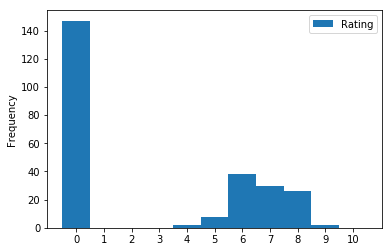

In [199]:
cs_venues[['Rating']].plot.hist(xticks=range(0,11), bins=np.arange(12)-0.5)

Let's look at the ratings on the city map.

In [244]:
# create map using latitude and longitude values
map_minsk = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, name, rating in zip(cs_venues['Venue Latitude'], cs_venues['Venue Longitude'], cs_venues['Venue'], cs_venues['Rating']):
    label = name
    folium.CircleMarker(
        location=[lat, lng],
        radius=3 + rating*2,
        color='brown',
        fill=True,
        fill_color='brown',
        fill_opacity=0.1
    ).add_to(map_minsk)

map_minsk

We can see that most of high-rated coffee shops are located in the city center and along the main transportation routes.

#### Price Tier

In [255]:
print('Percent price tier 2 venues:', cs_venues[cs_venues['Price Tier'] == 2].shape[0] / cs_venues.shape[0] * 100)

Percent price tier 2 venues: 7.905138339920949


Most coffee shops in Minsk work in low price tier and only 8% work in price tier 2.

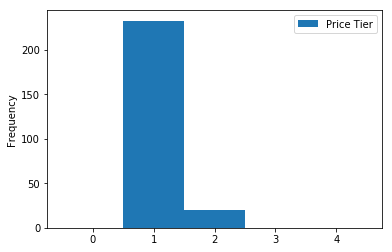

In [222]:
cs_venues[['Price Tier']].plot.hist(xticks=range(0,5), bins=np.arange(6)-0.5)

In [233]:
# create map using latitude and longitude values
map_minsk = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, name, price in zip(cs_venues['Venue Latitude'], cs_venues['Venue Longitude'], cs_venues['Venue'], cs_venues['Price Tier']):
    label = name
    folium.CircleMarker(
        location=[lat, lng],
        radius= 3 + (price-1)*10,
        color='brown',
        fill=True,
        fill_color='brown',
        fill_opacity=0.2
    ).add_to(map_minsk)

map_minsk

Most of more expensive coffee shops located in the city center.

#### Likes Count

If look at the like counts, we can see that 75% of coffee shops has less than 20 likes. At the same time, 
there are several venues with high count of likes in our data set.

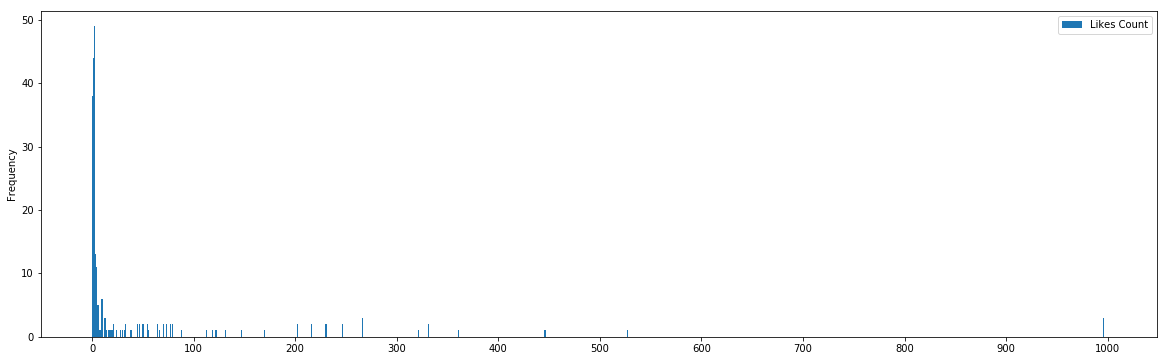

In [249]:
cs_venues[['Likes Count']].plot.hist(xticks=range(0, 1001, 100), bins=np.arange(0, 1000, 1)-0.5, figsize=(20,6))

In [256]:
cs_venues[cs_venues['Likes Count'] > 200]

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category,Rating,Price Tier,Likes Count,Tips Count
37,"пр. Независимости,46, 220005,г. Минск",53.914125,27.581544,Зерно,4f7afb6ae4b02579039ddc3f,53.912454,27.580379,Coffee Shop,8.2,2,996,352
41,"пр. Независимости,46, 220005,г. Минск",53.914125,27.581544,Wake Up Coffee. Кофе и десерты.,53c3ba44498e1eeb11b40e95,53.917610,27.578301,Coffee Shop,8.0,1,361,105
73,"пр. Независимости,20, 220008,г. Минск",53.900230,27.558361,Surf Coffee,5741af3b498e33efb94e7660,53.897226,27.559244,Coffee Shop,8.4,2,230,109
75,"пр. Независимости,20, 220008,г. Минск",53.900230,27.558361,Утопия60,55db436b498e4261950318f7,53.900239,27.560068,Coffee Shop,7.5,2,266,91
81,"пр. Независимости,20, 220008,г. Минск",53.900230,27.558361,GURU Coffee Club,50d5e1a4e4b047bbffbafc0e,53.897905,27.556354,Coffee Shop,7.1,1,202,72
86,"пр. Независимости,20, 220008,г. Минск",53.900230,27.558361,CoffeeBerry,4fde0188e4b0767cc76f5968,53.901065,27.552572,Coffee Shop,6.6,2,446,183
109,"ул. Советская,11, 220010,г. Минск",53.895632,27.545970,GURU Coffee Club,4f72cac4e4b00da52abbf286,53.893990,27.551338,Coffee Shop,7.0,2,247,128
137,"Привокзальная пл.,3, 220011,г. Минск",53.890977,27.553478,26,5700fbe0498ec48730b87f88,53.892074,27.555916,Coffee Shop,8.0,2,231,93
139,"Привокзальная пл.,3, 220011,г. Минск",53.890977,27.553478,GURU Coffee Club,4f72cac4e4b00da52abbf286,53.893990,27.551338,Coffee Shop,7.0,2,247,128
144,"Привокзальная пл.,3, 220011,г. Минск",53.890977,27.553478,Union Coffee,51e92736498e357b93338c6e,53.890241,27.554204,Coffee Shop,6.1,2,216,122


In [251]:
import math

# create map using latitude and longitude values
map_minsk = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, name, likes in zip(cs_venues['Venue Latitude'], cs_venues['Venue Longitude'], cs_venues['Venue'], cs_venues['Likes Count']):
    label = name
    folium.CircleMarker(
        location=[lat, lng],
        radius= 3 + math.log10(likes+1)*8,
        color='brown',
        fill=True,
        fill_color='brown',
        fill_opacity=0.1
    ).add_to(map_minsk)

map_minsk

Again, the popular coffee shops tend to be located in the city business center and along the main transportation routes 
(main avenues and the metro lines). The most popular coffee are clustered around two locations in the city center.

#### Tips Count

We can see, that tips count is highly correlated with number of likes venues have.

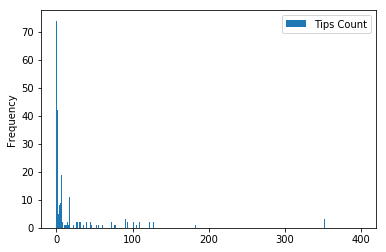

In [223]:
cs_venues[['Tips Count']].plot.hist(xticks=range(0, 401, 100), bins=np.arange(401)-0.5)

<a id="Explore_The_Neighborhoods"></a>
## Explore The Neighborhoods

In [105]:
neighborhoods = post_offices
neighborhoods.columns = ['Postalcode', 'Neighborhood', 'Latitude', 'Longitude']

Let's see how many venues have been returned for each neighborhood given the radius of 500 meters and the venue limit of 100.

In [175]:
minsk_venues.groupby('Neighborhood')['Neighborhood'].count()

Neighborhood
Логойский тр.,1, к.1, 220113,г. Минск           23
Логойский тракт,27, 220090,г. Минск              5
Привокзальная пл.,3, 220011,г. Минск            28
Старовиленский тр.,28/1, 220053,г. Минск         5
бул. Шевченко, 17, 220068,г. Минск               4
пр. Независимости, 95, 220043,г. Минск           4
пр. Независимости,103, 220023,г. Минск           5
пр. Независимости,131,к.1, 220114,г. Минск       4
пр. Независимости,20, 220008,г. Минск           34
пр. Независимости,46, 220005,г. Минск           30
пр. Независимости,91, 220012,г. Минск            4
пр. Партизанский, 107, 220021,г. Минск           3
пр. Партизанский, 147, 220102,г. Минск           1
пр. Партизанский,34, к.1, 220107,г. Минск        2
пр. Партизанский,34,к.1, 220026,г. Минск         2
пр. Победителей,123, , 220062, г. Минск,         4
пр. Победителей,21, 220126,г. Минск             13
пр. Рокоссовского, 33, 220094,г. Минск           3
пр. Рокоссовского, 49, 220111,г. Минск           4
пр. газеты «Звязда

In [174]:
minsk_venues.groupby('Neighborhood')['Neighborhood'].count().describe()

count    108.000000
mean       8.000000
std        9.086294
min        1.000000
25%        2.000000
50%        4.000000
75%       10.250000
max       34.000000
Name: Neighborhood, dtype: float64

We can see that _count_ is 108, which means that for 13 neighborhoods Foursquare does not return any coffee shop 
nor substitute venues. Maximal number of venues is 34 and median is only 4, just 25% of neighborhoods have more than 10
venues.

Let's find out how many unique categories can be curated from all the venues we got in **coffee** section.

In [97]:
print('There are {} uniques categories.'.format(len(minsk_venues['Venue Category'].unique())))

There are 28 uniques categories.


<a id="Analyze_Venues_in_The_Neighborhoods"></a>
### Analyze Venues in The Neighborhoods

In [98]:
# one hot encoding
minsk_onehot = pd.get_dummies(minsk_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
minsk_onehot['Neighborhood'] = minsk_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [minsk_onehot.columns[-1]] + list(minsk_onehot.columns[:-1])
minsk_onehot = minsk_onehot[fixed_columns]

minsk_onehot.head()

,Neighborhood,Bakery,Bar,Belarusian Restaurant,Bistro,Bookstore,Buffet,Cafeteria,Café,Candy Store,...,Gym / Fitness Center,Hookah Bar,Hot Dog Joint,Pizza Place,Restaurant,Rock Club,Sandwich Place,Shopping Mall,Steakhouse,Tea Room
0,"ул. Московская,16, 220001,г. Минск",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"ул. Московская,16, 220001,г. Минск",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"ул. Московская,16, 220001,г. Минск",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"ул. Московская,16, 220001,г. Минск",0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,"ул. Московская,16, 220001,г. Минск",0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


And let's examine the new dataframe size.

In [99]:
minsk_onehot.shape

(864, 29)

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category.

In [102]:
minsk_grouped = minsk_onehot.groupby('Neighborhood').mean().reset_index()
print ('Size of grouped data:', minsk_grouped.shape)

Size of grouped data: (108, 29)


Let's fill with 0 all the category frequencies for the neigborhoods that we got no venues.

In [108]:
minsk_grouped = neighborhoods[['Neighborhood']].merge(minsk_grouped, how='outer', on=['Neighborhood'])
minsk_grouped = minsk_grouped.fillna(0.0)
print ('Size of grouped data:', minsk_grouped.shape)

Size of grouped data: (121, 29)


In [109]:
minsk_grouped.head()

,Neighborhood,Bakery,Bar,Belarusian Restaurant,Bistro,Bookstore,Buffet,Cafeteria,Café,Candy Store,...,Gym / Fitness Center,Hookah Bar,Hot Dog Joint,Pizza Place,Restaurant,Rock Club,Sandwich Place,Shopping Mall,Steakhouse,Tea Room
0,"ул. Московская,16, 220001,г. Минск",0.0,0.000000,0.0,0.0,0.0,0.090909,0.0,0.272727,0.0,...,0.0,0.0,0.0,0.090909,0.000000,0.0,0.000000,0.0,0.090909,0.000000
1,"ул. Сторожевская,8, 220002,г. Минск",0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.666667,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
2,"ул. Одинцова, 113, 220003,г. Минск",0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
3,"ул. М.Танка,36, к.2, 220004,г. Минск",0.0,0.043478,0.0,0.0,0.0,0.000000,0.0,0.608696,0.0,...,0.0,0.0,0.0,0.043478,0.086957,0.0,0.000000,0.0,0.000000,0.043478
4,"пр. Независимости,46, 220005,г. Минск",0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.466667,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.033333,0.0,0.000000,0.033333


Let's find out what the top 5 most common venues for the first 3 neighborhoods in Minsk are.

In [110]:
num_top_venues = 5
num_neighborhoods = 3

for hood in minsk_grouped[:num_neighborhoods]['Neighborhood']:
    print("----"+hood+"----")
    temp = minsk_grouped[minsk_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----ул. Московская,16, 220001,г. Минск----
         venue  freq
0  Coffee Shop  0.36
1         Café  0.27
2   Steakhouse  0.09
3       Buffet  0.09
4  Pizza Place  0.09


----ул. Сторожевская,8, 220002,г. Минск----
         venue  freq
0         Café  0.67
1  Coffee Shop  0.33
2       Bakery  0.00
3   Donut Shop  0.00
4   Steakhouse  0.00


----ул. Одинцова, 113, 220003,г. Минск----
            venue  freq
0          Bakery   0.0
1             Bar   0.0
2      Steakhouse   0.0
3   Shopping Mall   0.0
4  Sandwich Place   0.0




It's interesting, that even first three neighborhoods look quite different: the first one shows approximately equal 
mix of Coffee Shop and Café venues, the second one has almost twice more Cafés than Coffee Shops, 
and there are no venues at all in the third one.

Let's put that into a pandas dataframe that displays the top 10 venues for each neighborhood.

In [111]:
num_top_venues = 10

# sorts the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

# create columns according to number of top venues
indicators = ['st', 'nd', 'rd']
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = minsk_grouped['Neighborhood']

for ind in np.arange(minsk_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(minsk_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"ул. Московская,16, 220001,г. Минск",Coffee Shop,Café,Pizza Place,Buffet,Donut Shop,Steakhouse,Tea Room,Bar,Belarusian Restaurant,Bistro
1,"ул. Сторожевская,8, 220002,г. Минск",Café,Coffee Shop,Tea Room,Steakhouse,Bar,Belarusian Restaurant,Bistro,Bookstore,Buffet,Cafeteria
2,"ул. Одинцова, 113, 220003,г. Минск",Tea Room,Steakhouse,Bar,Belarusian Restaurant,Bistro,Bookstore,Buffet,Cafeteria,Café,Candy Store
3,"ул. М.Танка,36, к.2, 220004,г. Минск",Café,Coffee Shop,Restaurant,Tea Room,Bar,Pizza Place,Eastern European Restaurant,Belarusian Restaurant,Bistro,Bookstore
4,"пр. Независимости,46, 220005,г. Минск",Café,Coffee Shop,Tea Room,Sandwich Place,Dessert Shop,College Cafeteria,Bar,Belarusian Restaurant,Bistro,Bookstore
5,"ул. Маяковского,8, 220006,г. Минск",Tea Room,Steakhouse,Bar,Belarusian Restaurant,Bistro,Bookstore,Buffet,Cafeteria,Café,Candy Store
6,"ул. Жуковского,6, к.2, 220007,г. Минск",Café,Coffee Shop,Tea Room,Steakhouse,Bar,Belarusian Restaurant,Bistro,Bookstore,Buffet,Cafeteria
7,"пр. Независимости,20, 220008,г. Минск",Coffee Shop,Café,French Restaurant,Dessert Shop,Eastern European Restaurant,Tea Room,Rock Club,Hookah Bar,Bookstore,Buffet
8,"ул. Чеботарева,1/6, 220009,г. Минск",Café,Coffee Shop,Tea Room,Steakhouse,Bar,Belarusian Restaurant,Bistro,Bookstore,Buffet,Cafeteria
9,"ул. Советская,11, 220010,г. Минск",Café,Coffee Shop,Bistro,Pizza Place,Tea Room,Donut Shop,Belarusian Restaurant,Chinese Restaurant,Cupcake Shop,Gym / Fitness Center


<a id="Cluster_The_Neighborhoods"></a>
### Cluster The Neighborhoods

Let's cluster the neighborhood into 4 clusters using *k*-means algorithm.

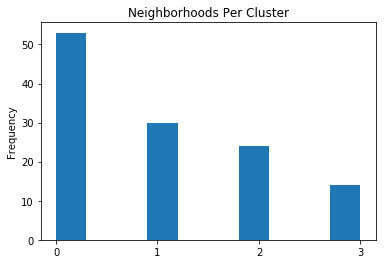

In [167]:
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 4

minsk_grouped_clustering = minsk_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=123).fit(minsk_grouped_clustering)

# check number of items in each cluster
pd.DataFrame(kmeans.labels_).plot.hist(legend='', title='Neighborhoods Per Cluster', xticks=range(0,4))

It looks like we found 4 reasonably sized clusters. Let's create a new dataframe that includes the clusters, as well as the top 10 venue categories for each neighborhood.

In [168]:
minsk_merged = pd.DataFrame(neighborhoods)

# add clustering labels
minsk_merged['Cluster Labels'] = kmeans.labels_

# merge grouped with data to add latitude/longitude for each neighborhood
minsk_merged = minsk_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

minsk_merged.head()

,Postalcode,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,220001,"ул. Московская,16, 220001,г. Минск",53.887819,27.538548,0,Coffee Shop,Café,Pizza Place,Buffet,Donut Shop,Steakhouse,Tea Room,Bar,Belarusian Restaurant,Bistro
1,220002,"ул. Сторожевская,8, 220002,г. Минск",53.914390,27.553282,0,Café,Coffee Shop,Tea Room,Steakhouse,Bar,Belarusian Restaurant,Bistro,Bookstore,Buffet,Cafeteria
2,220003,"ул. Одинцова, 113, 220003,г. Минск",53.901167,27.427478,3,Tea Room,Steakhouse,Bar,Belarusian Restaurant,Bistro,Bookstore,Buffet,Cafeteria,Café,Candy Store
3,220004,"ул. М.Танка,36, к.2, 220004,г. Минск",53.903750,27.565430,0,Café,Coffee Shop,Restaurant,Tea Room,Bar,Pizza Place,Eastern European Restaurant,Belarusian Restaurant,Bistro,Bookstore
4,220005,"пр. Независимости,46, 220005,г. Минск",53.914125,27.581544,0,Café,Coffee Shop,Tea Room,Sandwich Place,Dessert Shop,College Cafeteria,Bar,Belarusian Restaurant,Bistro,Bookstore


Let's check mean frequencies of venue categories in our clusters. 

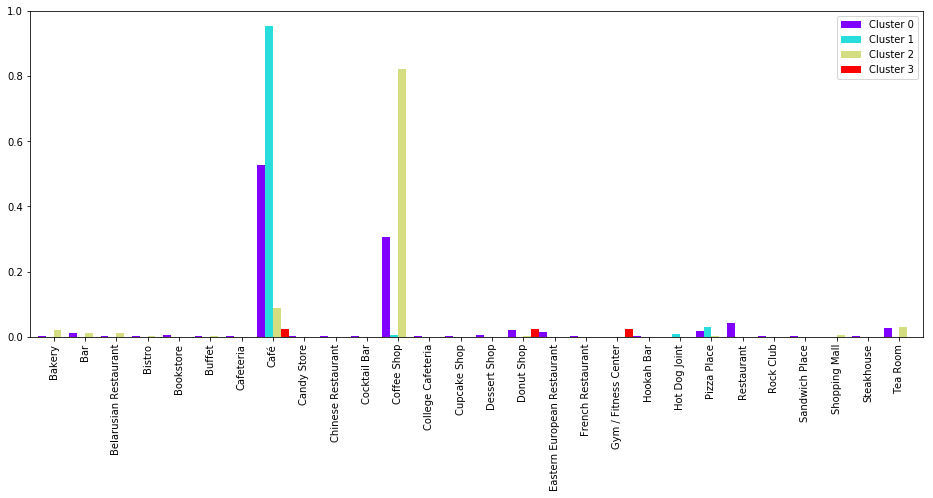

In [169]:
import matplotlib.cm as cm
import matplotlib.colors as colors

%matplotlib inline

colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

df = pd.DataFrame(minsk_grouped)
df['Cluster Labels'] = kmeans.labels_

cluster_df = pd.DataFrame(df[df['Cluster Labels'] == 0].mean(), columns=['Cluster 0'])
for cluster in range(1,kclusters):
    df2 = pd.DataFrame(df[df['Cluster Labels'] == cluster].mean(), columns=['Cluster {}'.format(cluster)])
    cluster_df = cluster_df.join(df2)
    
cluster_df = cluster_df.drop('Cluster Labels', axis=0)

cluster_df.plot.bar(figsize=(16,6), color=rainbow, width=1)

So, we can describe our clusters in the following way:
- **Cluster 0** - mixes Cafe and Coffee Shop venues
- **Cluster 1** - most of venues are Cafes
- **Cluster 2** - most of venues are Coffee Shops
- **Cluster 3** - almost missing venues in the categories we looked for

Finally, let's visualize the resulting clusters on the city map.

In [172]:
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]

# create map
map_clusters = folium.Map(location=[latitude, longitude], tiles='Stamen Toner', zoom_start=12)

# add markers to the map
for lat, lon, poi, cluster in zip(minsk_merged['Latitude'], minsk_merged['Longitude'], minsk_merged['Neighborhood'], minsk_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' / Cluster ' + str(cluster), parse_html=True)
    folium.Circle(
        [lat, lon],
        radius=500,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.5).add_to(map_clusters)
       
map_clusters

We can made several observations on how neighboors that belongs to different clusters are distributed on the map:
* Neighborhoods with mix of Cafe and Coffee Shop venues are located in the city center and along the metro lines.
* Neighborhoods where most of the venues are Cafes located in residential areas, we can see more even distribution in this case.
* Neighborhoods where Coffee Shops make up the majority of the venues are located near the transport and shopping hubs.
* Several neighborhoods located in industrial sub-areas almost don't have coffee-related venues.